# Variational Auto Encoder with MNIST (or Fashion MNIST)

* `Auto-Encoding Variational Bayes` [arXiv:1312.6114](https://arxiv.org/abs/1312.6114)
  * Diederik P. Kingma and Max Welling

* This code is available to tensorflow version 2.0
* Implemented by [`tf.keras.layers`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers) [`tf.losses`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/losses)
* This code refers to [TensorFlow official tutorial vae code](https://github.com/tensorflow/tensorflow/blob/r1.13/tensorflow/contrib/eager/python/examples/generative_examples/cvae.ipynb).

## 1. Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import sys
import time
import glob

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
import imageio
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers

os.environ["CUDA_VISIBLE_DEVICES"]="0"

## 2. Setting hyperparameters

In [2]:
# Training Flags (hyperparameter configuration)
model_name = 'vae'
train_dir = os.path.join('train', model_name, 'exp1')

max_epochs = 100
save_model_epochs = 5
print_steps = 100
save_images_epochs = 2
batch_size = 128
learning_rate = 1e-4
num_examples_to_generate = 1024
latent_dim = 2
MNIST_SIZE = 28

## 3. Load the MNIST dataset

In [3]:
# Load training and eval data from tf.keras
(train_images, train_labels), (test_images, test_labels) = \
    tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(-1, MNIST_SIZE, MNIST_SIZE, 1).astype('float32')
train_images = train_images / 255.

test_images = test_images.reshape(-1, MNIST_SIZE, MNIST_SIZE, 1).astype('float32')
test_images = test_images / 255.

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)


## 4. Set up dataset with `tf.data`

### create input pipeline with `tf.data.Dataset`

In [4]:
#tf.random.set_seed(219)

# for train
N = len(train_images)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=N)
train_dataset = train_dataset.batch(batch_size=batch_size)
print(train_dataset)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.shuffle(buffer_size=len(test_images))
test_dataset = test_dataset.batch(batch_size=num_examples_to_generate)
print(test_dataset)

<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.uint8)>
<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.uint8)>


## 5. Create the AutoEncoder models

In [5]:
class Conv(tf.keras.Model):
  def __init__(self, filters, kernel_size, strides, padding='same',
               activation='relu', apply_batchnorm=True, norm_momentum=0.9, norm_epsilon=1e-5,
               leaky_relu_alpha=0.2, name='conv_layer', kernel_constraint=None):
    super(Conv, self).__init__(name=name)
    assert activation in ['relu', 'leaky_relu', 'none']
    self.activation = activation
    self.apply_batchnorm = apply_batchnorm
    self.leaky_relu_alpha = leaky_relu_alpha

    self.conv = layers.Conv2D(filters=filters,
                              kernel_size=(kernel_size, kernel_size),
                              strides=strides,
                              padding=padding,
                              kernel_initializer=tf.random_normal_initializer(0., 0.02),
                              kernel_constraint=kernel_constraint,
                              use_bias=not self.apply_batchnorm)
    if self.apply_batchnorm:
      self.batchnorm = layers.BatchNormalization(momentum=norm_momentum,
                                                 epsilon=norm_epsilon)

  def call(self, x, training=True):
    # convolution
    x = self.conv(x)

    # batchnorm
    if self.apply_batchnorm:
      x = self.batchnorm(x, training=training)

    # activation
    if self.activation == 'relu':
      x = tf.nn.relu(x)
    elif self.activation == 'leaky_relu':
      x = tf.nn.leaky_relu(x, alpha=self.leaky_relu_alpha)
    else:
      pass

    return x
    
class Encoder(tf.keras.Model):
  def __init__(self, latent_dim=latent_dim):
    super(Encoder, self).__init__()
    self.conv1 = Conv(32, 3, 2, padding='valid', apply_batchnorm=False)
    self.conv2 = Conv(64, 3, 2, padding='valid', apply_batchnorm=False)
    self.flatten = layers.Flatten()
    self.fc = layers.Dense(units=latent_dim * 2)
    
  def call(self, inputs):
    """Run the model."""
    x = self.conv1(inputs)
    x = self.conv2(x)
    x = self.flatten(x)
    x = self.fc(x)
    
    return x

In [6]:
class ConvTranspose(tf.keras.Model):
  def __init__(self, filters, kernel_size, strides=2, padding='same',
               activation='relu', apply_batchnorm=True, norm_momentum=0.9, norm_epsilon=1e-5,
               name='conv_transpose_layer'):
    super(ConvTranspose, self).__init__(name=name)
    assert activation in ['relu', 'sigmoid', 'tanh', 'none']
    self.activation = activation
    self.apply_batchnorm = apply_batchnorm

    self.up_conv = layers.Conv2DTranspose(filters=filters,
                                          kernel_size=(kernel_size, kernel_size),
                                          strides=strides,
                                          padding=padding,
                                          kernel_initializer=tf.random_normal_initializer(0., 0.02),
                                          use_bias=not self.apply_batchnorm)
    if self.apply_batchnorm:
      self.batchnorm = layers.BatchNormalization(momentum=norm_momentum,
                                                 epsilon=norm_epsilon)

  def call(self, x, training=True):
    # conv transpose
    x = self.up_conv(x)
    
    # batchnorm
    if self.apply_batchnorm:
      x = self.batchnorm(x, training=training)
      
    # activation
    if self.activation == 'relu':
      x = tf.nn.relu(x)
    elif self.activation == 'sigmoid':
      x = tf.nn.sigmoid(x)
    elif self.activation == 'tanh':
      x = tf.nn.tanh(x)
    else:
      pass
    
    return x
    
class Decoder(tf.keras.Model):
  def __init__(self):
    super(Decoder, self).__init__()
    self.fc = layers.Dense(units=7*7*32, activation='relu')
    self.reshape = layers.Reshape(target_shape=(7, 7, 32))
    self.conv1 = ConvTranspose(64, 3, 2, apply_batchnorm=False)
    self.conv2 = ConvTranspose(32, 3, 2, apply_batchnorm=False)
    self.conv3 = ConvTranspose(1, 3, 1, activation='none', apply_batchnorm=False)    
    
  def call(self, inputs):
    """Run the model."""
    x = self.fc(inputs)
    x = self.reshape(x)
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    
    return x

In [7]:
class VariationalAutoEncoder(tf.keras.Model):
  """Build a Variational Auto Encoder
  """
  def __init__(self, latent_dim=latent_dim):
    super(VariationalAutoEncoder, self).__init__()
    self.global_step = tf.Variable(0, trainable=False)
    self.latent_dim = latent_dim
    self.encoder = Encoder(self.latent_dim)
    self.decoder = Decoder()
    
  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar
  
  def reparameterize(self, mean, logvar):
    epsilon = tf.random.normal(shape=mean.shape)
    return mean + tf.exp(logvar * .5) * epsilon
  
  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.math.sigmoid(logits)
      return probs
    return logits

  def sample(self, num_examples_to_generate=num_examples_to_generate, epsilon=None):
    if epsilon is None:
      epsilon = tf.random.normal(shape=(num_examples_to_generate, self.latent_dim))
    return self.decode(epsilon, apply_sigmoid=True)

In [8]:
vae = VariationalAutoEncoder()
print(vae)

## 6. Define the loss functions and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, we optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

**Note**: we could also analytically compute the KL term, but here we incorporate all three terms in the Monte Carlo estimator for simplicity.

**Normal distribution**

$$ \mathcal{N}(\mu, \sigma) = \frac{1}{\sqrt{2\pi \sigma^{2}}} \exp \left( {-\frac{(x-\mu)^{2}}{2\sigma^{2}}} \right) $$

**Log normal distribution**

$$ \log \mathcal{N}(\mu, \sigma) = -\frac{1}{2} \log(2 \pi \sigma^{2}) + \left[ -\frac{(x-\mu)^{2}}{2\sigma^{2}} \right] $$

$$ = -\frac{1}{2} \left[ \log(2 \pi) + \log(\sigma^{2}) + \frac{(x-\mu)^{2}}{\sigma^{2}} \right] $$

$$ = -\frac{1}{2} \left[ \log(2 \pi) + \log(\sigma^{2}) + (x-\mu)^{2} \exp(-log(\sigma^{2})) \right] $$

In [9]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return -.5 * tf.reduce_sum((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi, axis=raxis)

In [10]:
def vae_loss(inputs, logits, z, z_mean, z_logvar):
  """Calculate the VAE loss
  reconstruction loss + KL divergence loss
  for each dataset in minibatch.
  Args:
    inputs (4-rank T): input images (for target labels)
    logits (4-rank T): logits of reconstructed images from P(X|z) for reconstruction loss
    z_mean (1-rank T): Multi variate normal distribution parameters
    z_logvar (1-rank T): Multi variate normal distribution parameters
  Returns:
    loss (0-rank T): reconstruction loss + KL divergence loss
  """
  # reconstruction loss, $$\log p(x| z)$$
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=inputs)
  reconstructios_loss = tf.reduce_sum(cross_ent, axis=[1, 2, 3]) # logpx_z

  # KL Divergence D_KL( Q(z|X) || P(z) )
  # formula 1:
  KL_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mean**2 - 1. - z_logvar, 1)

  # formula 2:
  #logpz = log_normal_pdf(z, 0., 0.)
  #logqz_x = log_normal_pdf(z, z_mean, z_logvar)
  #KL_loss = logqz_x - logpz

  return tf.reduce_mean(reconstructios_loss + KL_loss)

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate)

## 7. Training

In [12]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
const_random_vector_for_saving = tf.random.normal([num_examples_to_generate, latent_dim])

### Define training one step function

In [13]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  with tf.GradientTape() as tape: 
    mean, logvar = vae.encode(images)
    z = vae.reparameterize(mean, logvar)
    x_logits = vae.decode(z)

    loss = vae_loss(images, x_logits, z, mean, logvar)

  gradients = tape.gradient(loss, vae.trainable_variables)
  optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
  
  return loss

### 출력을 위해 필요한 함수 구현

In [14]:
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def get_z_mesh():
    x_grid = np.linspace(-3, 3, 10)
    y_grid = np.linspace(3, -3, 10)
    xv, yv = np.meshgrid(x_grid, y_grid)
    z_mesh = np.stack([xv, yv], axis=2)
    
    return z_mesh

### Train full steps

Unconditional Samples


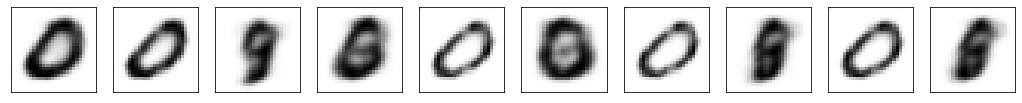

Input Images


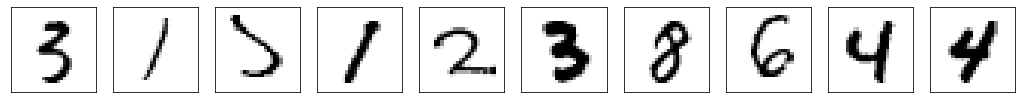

Output Images


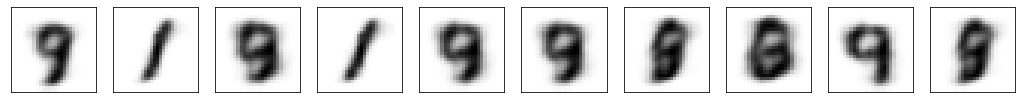

Embedding Z vectors


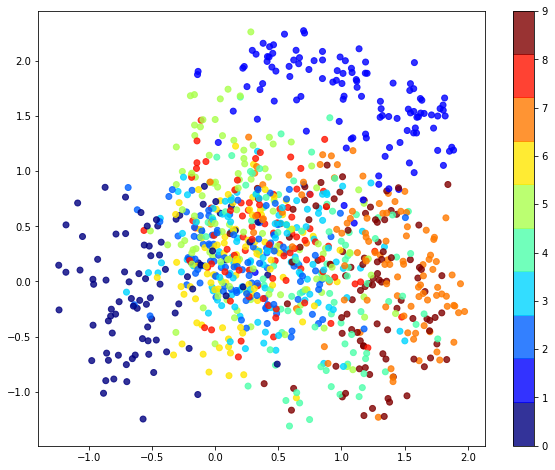

Decoded Images in Meshgrid


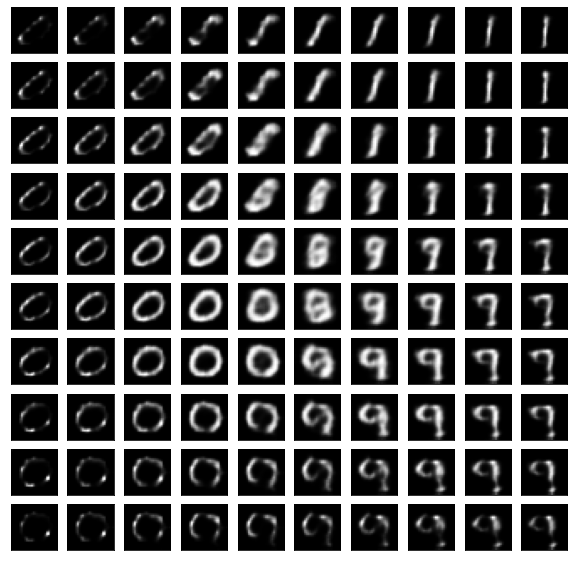

global step : 3100 loss : 172.42575
global step : 3200 loss : 174.33432
global step : 3300 loss : 164.07103
global step : 3400 loss : 179.92175
global step : 3500 loss : 174.88606
global step : 3600 loss : 169.46365
global step : 3700 loss : 171.79434
global step : 3800 loss : 171.06071
global step : 3900 loss : 175.34418


KeyboardInterrupt: ignored

In [15]:
print('Start Training.')
for epoch in range(max_epochs):  
  for step, (images, labels) in enumerate(train_dataset):
    loss = train_step(images)
    vae.global_step.assign_add(1)
    global_step = vae.global_step.numpy()

    if global_step % 100 == 0:
      print('global step :', global_step, 'loss :', loss.numpy())

    if global_step % 1000 == 0:
      display.clear_output(wait=True)
      for test_images, test_labels in test_dataset:
        break
      # Samples            
      sample_images = vae.sample(num_examples_to_generate, const_random_vector_for_saving)
      print('Unconditional Samples')
      plt.figure(figsize=[18, 3])
      for j in range(10):
          plt.subplot(1, 10, j+1)
          plt.imshow(sample_images[j, :, :, 0], cmap='binary')
          plt.xticks([])
          plt.yticks([])
      plt.show()

      # Inputs
      print('Input Images')
      plt.figure(figsize=[18, 3])
      for j in range(10):
          plt.subplot(1, 10, j+1)
          plt.imshow(test_images[j, :, :, 0], cmap='binary')
          plt.xticks([])
          plt.yticks([])
      plt.show()

      # Outputs
      mean, logvar = vae.encode(test_images)
      z = vae.reparameterize(mean, logvar)
      x_logits = vae.decode(z, apply_sigmoid=True)

      print('Output Images')
      plt.figure(figsize=[18, 3])
      for j in range(10):
          plt.subplot(1, 10, j+1)
          plt.imshow(x_logits[j, :, :, 0], cmap='binary')
          plt.xticks([])
          plt.yticks([])
      plt.show()

      # Plot embedding Z vectors
      print('Embedding Z vectors')
      plt.figure(figsize=[10, 8])
      plt.scatter(z[:, 0], z[:, 1], c=test_labels, cmap=discrete_cmap(10, 'jet'), alpha=0.8)
      plt.colorbar()
      plt.show()

      # Plot decoded images of Z vectors in meshgrid 
      z_mesh = get_z_mesh().reshape([-1, 2])
      z_mesh = tf.convert_to_tensor(z_mesh)
      x_mesh = vae.decode(z_mesh, apply_sigmoid=True)
      x_mesh = tf.reshape(x_mesh, [-1, 28, 28])
      print('Decoded Images in Meshgrid')
      plt.figure(figsize=[10, 10])
      for x_index in range(10):
          for y_index in range(10):
              plt.subplot(10, 10, x_index + 1 + y_index * 10)
              plt.xticks([], [])
              plt.yticks([], [])
              plt.imshow(x_mesh[x_index + y_index * 10], cmap='gray')
      plt.show()  
    
print('Training Done.')